# Установка и настройка окружения
Что происходит: Устанавливаются все зависимости, необходимые для обучения CNN.

In [14]:
# ============================================
# 📦 Install dependencies & Kaggle setup
# ============================================

!pip install -q kaggle torch torchvision tqdm      # установка необходимых библиотек

# Подключение Kaggle и загрузка датасета

In [ ]:
from google.colab import files                     # модуль для загрузки файлов в Colab
files.upload()                                     # загрузка kaggle.json (API-токен)

In [19]:
!mkdir -p ~/.kaggle                                # создаём папку .kaggle
!mv kaggle.json ~/.kaggle/                         # перемещаем kaggle.json в нужную папку
!chmod 600 ~/.kaggle/kaggle.json                   # задаём безопасные права доступа

In [20]:
!kaggle datasets download -d sanikamal/rock-paper-scissors-dataset  # скачиваем датасет с Kaggle
!unzip -q rock-paper-scissors-dataset.zip                           # распаковываем архив

Dataset URL: https://www.kaggle.com/datasets/sanikamal/rock-paper-scissors-dataset
License(s): other
rock-paper-scissors-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Rock-Paper-Scissors/test/paper/testpaper01-00.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Подготовка данных

In [23]:
import os                                        # работа с файловой системой
import random                                    # генерация случайных чисел
import numpy as np                               # численные операции
import torch                                     # основной PyTorch

In [24]:
def set_seed(seed=42):                            # функция для воспроизводимости
    random.seed(seed)                            # фиксируем random
    np.random.seed(seed)                         # фиксируем numpy
    torch.manual_seed(seed)                      # фиксируем PyTorch
set_seed()                                       # применяем фиксированный seed

# Transforms и DataLoader

In [25]:
from torchvision import datasets, transforms      # датасеты и трансформации torchvision
from torch.utils.data import DataLoader           # загрузчик данных
data_dir = "Rock-Paper-Scissors"                  # корневая папка датасета
data_transforms = {                               # словарь трансформаций
    "train": transforms.Compose([                 # трансформации для обучения
        transforms.RandomResizedCrop(224),        # случайный кроп до 224x224
        transforms.RandomHorizontalFlip(),        # случайное отражение
        transforms.ToTensor(),                    # преобразование в тензор
        transforms.Normalize(                     # нормализация по ImageNet
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]
        )
    ]),
    "val": transforms.Compose([                   # трансформации для валидации
        transforms.Resize(256),                   # изменение размера
        transforms.CenterCrop(224),               # центральный кроп
        transforms.ToTensor(),                    # преобразование в тензор
        transforms.Normalize(                     # нормализация
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]
        )
    ])
}
image_datasets = {                                # создаём ImageFolder датасеты
    "train": datasets.ImageFolder(                # обучающая выборка
        os.path.join(data_dir, "train"),
        data_transforms["train"]
    ),
    "val": datasets.ImageFolder(                  # валидационная выборка (test)
        os.path.join(data_dir, "test"),
        data_transforms["val"]
    )
}
dataloaders = {                                   # создаём DataLoader'ы
    "train": DataLoader(                          # DataLoader для train
        image_datasets["train"],
        batch_size=32,                            # размер батча
        shuffle=True                              # перемешивание данных
    ),
    "val": DataLoader(                            # DataLoader для val
        image_datasets["val"],
        batch_size=32,
        shuffle=False                             # без перемешивания
    )
}
dataset_sizes = {                                 # размеры выборок
    x: len(image_datasets[x]) for x in ["train", "val"]
}
class_names = image_datasets["train"].classes     # названия классов (rock, paper, scissors)

# Визуализируем датасет

In [26]:
import matplotlib.pyplot as plt                  # библиотека для визуализации
import numpy as np                               # работа с массивами
import torchvision                               # утилиты для computer vision

def imshow(inp, title=None):                     # функция отображения батча изображений
    inp = inp.numpy().transpose((1, 2, 0))       # перевод тензора (C,H,W) → (H,W,C)

    mean = np.array([0.485, 0.456, 0.406])       # средние значения ImageNet
    std = np.array([0.229, 0.224, 0.225])        # стандартные отклонения ImageNet

    inp = std * inp + mean                       # денормализация изображения
    inp = np.clip(inp, 0, 1)                     # ограничение значений [0,1]

    plt.imshow(inp)                              # отображение изображения
    plt.xticks([])                               # убираем деления по оси X
    plt.yticks([])                               # убираем деления по оси Y

    if title is not None:                        # если есть заголовок
        plt.title(title)                         # устанавливаем заголовок

    plt.show()                                   # показываем изображение

# Получение и отображение батча данных

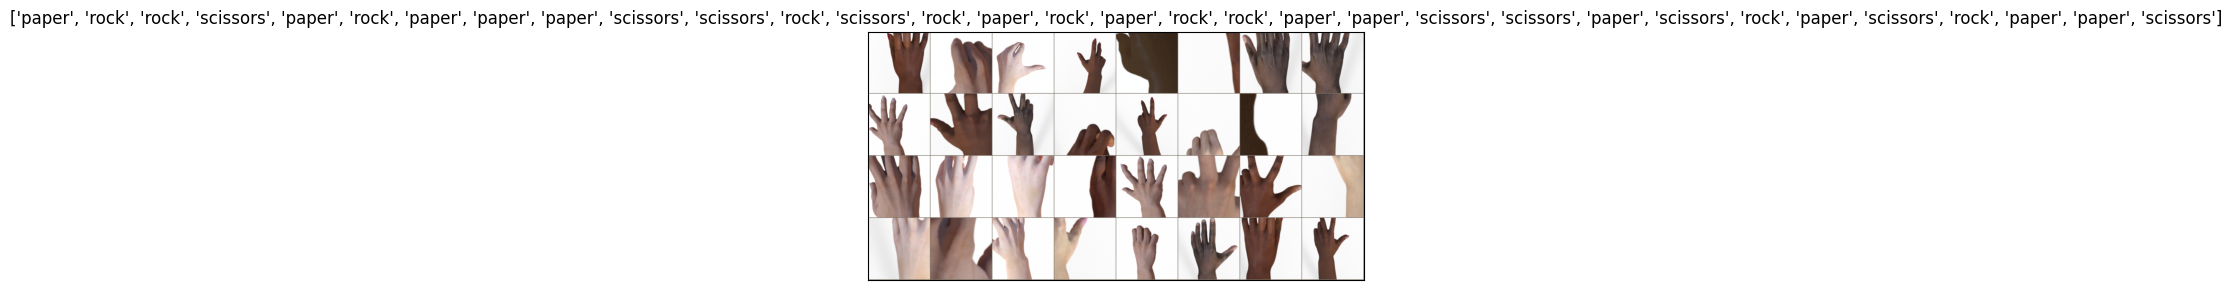

In [27]:
inputs, classes = next(iter(dataloaders['train']))   # получаем один батч из train DataLoader

out = torchvision.utils.make_grid(inputs)            # собираем изображения в сетку

imshow(out, title=[class_names[x] for x in classes]) # отображаем сетку с названиями классов

# Функция обучения модели

In [28]:
# ============================================
# 🏋️ Model training function
# ============================================

import time                                         # измерение времени
import copy                                         # копирование весов модели
from tqdm import tqdm                               # progress bar
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):  # функция обучения
    best_model_wts = copy.deepcopy(model.state_dict())  # сохраняем лучшие веса
    best_acc = 0.0                                     # лучшая точность
    for epoch in range(num_epochs):                    # цикл по эпохам
        print(f"\nEpoch {epoch+1}/{num_epochs}")       # вывод номера эпохи
        for phase in ["train", "val"]:                 # фазы train и val
            model.train() if phase == "train" else model.eval()  # режим модели
            running_loss = 0.0                          # накопление loss
            running_corrects = 0                        # количество верных предсказаний
            for inputs, labels in tqdm(dataloaders[phase]):  # перебор батчей
                inputs = inputs.to(device)              # перенос данных на GPU/CPU
                labels = labels.to(device)              # перенос меток
                optimizer.zero_grad()                   # обнуляем градиенты
                with torch.set_grad_enabled(phase == "train"):  # считаем градиенты только в train
                    outputs = model(inputs)             # прямой проход
                    loss = criterion(outputs, labels)   # считаем loss
                    preds = outputs.argmax(dim=1)       # получаем предсказания
                    if phase == "train":                # если обучение
                        loss.backward()                 # обратное распространение
                        optimizer.step()                # шаг оптимизации
                running_loss += loss.item() * inputs.size(0)  # суммарный loss
                running_corrects += (preds == labels).sum()   # считаем верные ответы
            if phase == "train":
                scheduler.step()                        # обновляем learning rate
            epoch_acc = running_corrects.double() / dataset_sizes[phase]  # accuracy эпохи
            print(f"{phase} accuracy: {epoch_acc:.4f}")                    # вывод accuracy
            if phase == "val" and epoch_acc > best_acc: # если улучшили результат
                best_acc = epoch_acc                    # сохраняем лучшую точность
                best_model_wts = copy.deepcopy(model.state_dict())  # сохраняем веса
    model.load_state_dict(best_model_wts)               # загружаем лучшие веса
    return model                                       # возвращаем модель

# Обучение ResNet-18 с нуля

In [29]:
# ============================================
# 🔨 Training ResNet-18 from scratch
# ============================================

from torchvision import models                         # готовые архитектуры
import torch.nn as nn                                  # слои нейросети
import torch.optim as optim                            # оптимизаторы
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # выбор устройства
model_scratch = models.resnet18(weights=None)          # ResNet-18 без предобучения
model_scratch.fc = nn.Linear(                          # замена последнего слоя
    model_scratch.fc.in_features, 3
)
model_scratch.to(device)                               # перенос модели на устройство
criterion = nn.CrossEntropyLoss()                      # функция потерь
optimizer = optim.SGD(                                 # оптимизатор SGD
    model_scratch.parameters(),
    lr=0.001,
    momentum=0.9
)
scheduler = optim.lr_scheduler.StepLR(                 # scheduler learning rate
    optimizer,
    step_size=7,
    gamma=0.1
)
model_scratch = train_model(model_scratch, criterion, optimizer, scheduler)  # обучение


Epoch 1/5


100%|██████████| 79/79 [00:21<00:00,  3.72it/s]


train accuracy: 0.4722


100%|██████████| 12/12 [00:02<00:00,  5.62it/s]


val accuracy: 0.3495

Epoch 2/5


100%|██████████| 79/79 [00:19<00:00,  4.07it/s]


train accuracy: 0.7187


100%|██████████| 12/12 [00:02<00:00,  4.84it/s]


val accuracy: 0.5699

Epoch 3/5


100%|██████████| 79/79 [00:19<00:00,  4.03it/s]


train accuracy: 0.8060


100%|██████████| 12/12 [00:02<00:00,  5.88it/s]


val accuracy: 0.7796

Epoch 4/5


100%|██████████| 79/79 [00:20<00:00,  3.81it/s]


train accuracy: 0.8492


100%|██████████| 12/12 [00:02<00:00,  5.82it/s]


val accuracy: 0.7419

Epoch 5/5


100%|██████████| 79/79 [00:19<00:00,  3.95it/s]


train accuracy: 0.8619


100%|██████████| 12/12 [00:02<00:00,  5.83it/s]

val accuracy: 0.7500


# Fine-tuning pretrained ResNet-18

In [30]:
# ============================================
# 🚀 Fine-tuning pretrained ResNet-18
# ============================================

model_pretrained = models.resnet18(                  # загружаем ResNet-18,
    weights="IMAGENET1K_V1"                           # предобученную на ImageNet
)

for param in model_pretrained.parameters():          # перебираем все параметры модели
    param.requires_grad = False                      # замораживаем все слои (no backprop)

model_pretrained.fc = nn.Linear(                     # заменяем последний полносвязный слой
    model_pretrained.fc.in_features,                 # число входных признаков
    3                                                 # число классов (rock, paper, scissors)
)

model_pretrained.to(device)                          # переносим модель на GPU / CPU

optimizer = optim.SGD(                               # оптимизатор SGD
    model_pretrained.fc.parameters(),                # обучаем ТОЛЬКО последний слой
    lr=0.001,                                        # learning rate
    momentum=0.9                                     # momentum для ускорения сходимости
)

scheduler = optim.lr_scheduler.StepLR(               # scheduler для learning rate
    optimizer,                                       # оптимизатор
    step_size=7,                                     # шаг изменения LR
    gamma=0.1                                        # коэффициент уменьшения LR
)

model_pretrained = train_model(model_pretrained, criterion, optimizer, scheduler)



Epoch 1/5


100%|██████████| 79/79 [00:15<00:00,  5.10it/s]


train accuracy: 0.6885


100%|██████████| 12/12 [00:02<00:00,  5.48it/s]


val accuracy: 0.7419

Epoch 2/5


100%|██████████| 79/79 [00:16<00:00,  4.89it/s]


train accuracy: 0.8544


100%|██████████| 12/12 [00:02<00:00,  5.26it/s]


val accuracy: 0.8145

Epoch 3/5


100%|██████████| 79/79 [00:15<00:00,  5.04it/s]


train accuracy: 0.8726


100%|██████████| 12/12 [00:02<00:00,  5.44it/s]


val accuracy: 0.8441

Epoch 4/5


100%|██████████| 79/79 [00:16<00:00,  4.93it/s]


train accuracy: 0.8821


100%|██████████| 12/12 [00:02<00:00,  4.74it/s]


val accuracy: 0.8683

Epoch 5/5


100%|██████████| 79/79 [00:15<00:00,  5.00it/s]


train accuracy: 0.8889


100%|██████████| 12/12 [00:02<00:00,  5.48it/s]

val accuracy: 0.8575


## Итоговый вывод

Fine-tuning предобученной ResNet-18:
- улучшил точность на ~9%
- сократил время обучения
- снизил риск переобучения

Это подтверждает эффективность transfer learning для задач компьютерного зрения при ограниченном размере датасета.